In [1]:
import numpy as np
example = np.load('lab1_example.npz', allow_pickle=True)['example'].item()


In [2]:
example["frames"].shape

(91, 400)

In [3]:
example["samples"].shape

(18432,)

In [4]:
400*91

36400

In [5]:
data = np.load('lab1_data.npz', allow_pickle=True)['data']
data

array([{'filename': '/home/giampi/corpora/tidigits/disc_4.2.1/tidigits/test/man/bm/oa.wav', 'samplingrate': 20000, 'gender': 'man', 'speaker': 'bm', 'digit': 'o', 'repetition': 'a', 'samples': array([-2, -1, -3, ..., 10,  8,  5], dtype=int16)},
       {'filename': '/home/giampi/corpora/tidigits/disc_4.2.1/tidigits/test/man/bm/ob.wav', 'samplingrate': 20000, 'gender': 'man', 'speaker': 'bm', 'digit': 'o', 'repetition': 'b', 'samples': array([  0,   0,   4, ..., -14, -12, -11], dtype=int16)},
       {'filename': '/home/giampi/corpora/tidigits/disc_4.2.1/tidigits/test/man/bm/za.wav', 'samplingrate': 20000, 'gender': 'man', 'speaker': 'bm', 'digit': 'z', 'repetition': 'a', 'samples': array([-1,  0, -3, ...,  0,  0, -2], dtype=int16)},
       {'filename': '/home/giampi/corpora/tidigits/disc_4.2.1/tidigits/test/man/bm/zb.wav', 'samplingrate': 20000, 'gender': 'man', 'speaker': 'bm', 'digit': 'z', 'repetition': 'b', 'samples': array([ 1, -1, -4, ...,  8,  9,  9], dtype=int16)},
       {'filen

## enframe

In [6]:
def enframe(samples, winlen, winshift):
    """
    Slices the input samples into overlapping windows. One row in the matrix is one frame. Frames overlapp based on winshift.

    Args:
        winlen: window length in samples.
        winshift: shift of consecutive windows in samples
    Returns:
        numpy array [N x winlen], where N is the number of windows that fit
        in the input signal
    """
    n_frames = ((samples.size - winlen) // winshift) + 1
    output = np.zeros((n_frames,winlen))
    for i in range(0, n_frames):
        output[i] = samples[i*winshift:i*winshift+winlen]
    return output

In [7]:
out=enframe(example["samples"],400,200)
out.shape

(91, 400)

In [8]:
np.sum(out!=example["frames"])

0

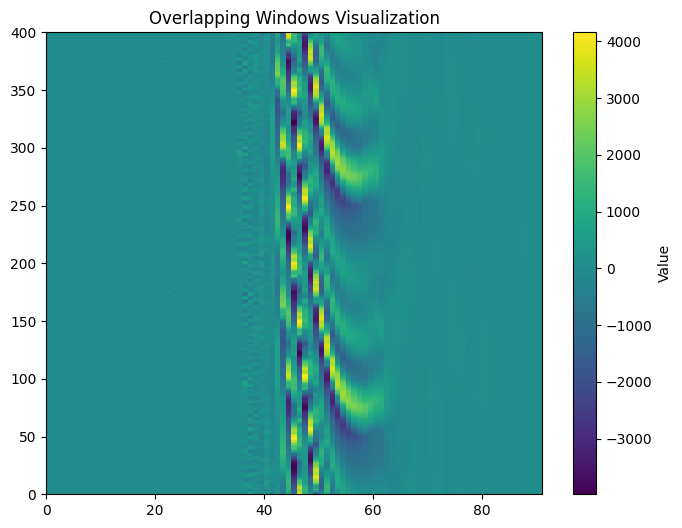

In [62]:
import matplotlib.pyplot as plt
def plot(data,xlabel="",ylabel="",title="Overlapping Windows Visualization"):
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(data, cmap='viridis')
    plt.colorbar(label='Value')
    #plt.xlim(0,400)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
plot(out.T,xlabel="")

## pre-emphasis

In [10]:
from scipy.signal import lfilter
def preemp(frames, alpha=0.97):
    """
    Applies a pre-emphasis filter to each frame. A type of normalization of the signal.  Speech signals tend to have a spectral tilt, meaning that energy
    decreases as frequency increases. The pre-emphasis filter counters this by boosting the high frequencies, making the spectral distribution more uniform 
    and improving the efficiency of subsequent processing steps like encoding or spectral analysis.
    
    The pre-emphasis effectively highlights the high-frequency components of the input frame.

    Args:
        frames: 2D numpy array of frames from enframe function.
        alpha: Pre-emphasis coefficient.
    Returns:
        A 2D numpy array with the filtered frames.
    """
    b = [1, -alpha]  # numerator coefficients
    a = [1]  # denominator coefficients
    return np.array([lfilter(b, a, frame) for frame in frames])

In [11]:
np.sum(preemp(enframe(example["samples"],400,200))!=example["preemph"])

0

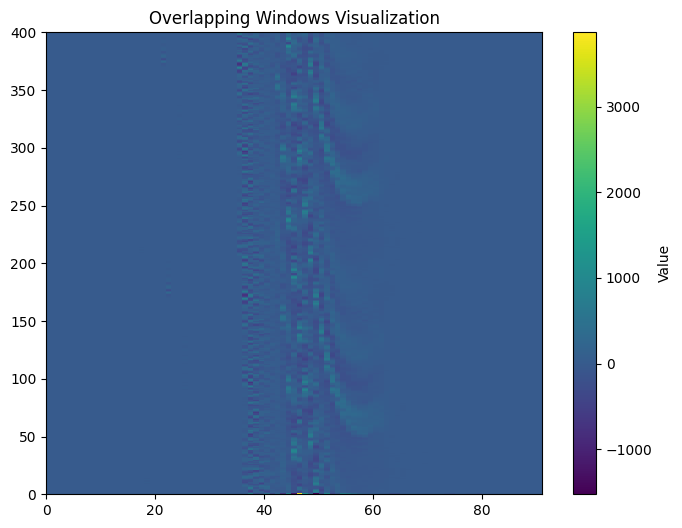

In [12]:
plot(preemp(enframe(example["samples"],400,200)).T)

## hamming window

In [13]:
from scipy.signal import hamming
# Function to apply a Hamming window to each frame
def apply_window(frames, sym=False):
    """
    Applies a Hamming window to each frame. "Smoothes" the start and end of each block in order for the FFT to better be able to model the peaks of the signals due to the FFT
    considering a copy of the frame to the left and right.

    Args:
        frames: 2D numpy array of frames.
        sym: When False (default), generates a periodic window, suitable for spectral analysis.
    Returns:
        A 2D numpy array with the windowed frames.
    """
    num_samples = frames.shape[1]  # number of samples in each frame
    hamming_window = hamming(num_samples, sym=sym)
    return frames * hamming_window

In [14]:
ham=apply_window(preemp(enframe(example["samples"],400,200)))

C:\Users\axels\AppData\Local\Temp\ipykernel_18748\1403223275.py:15: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated since SciPy 1.1.0 and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  hamming_window = hamming(num_samples, sym=sym)


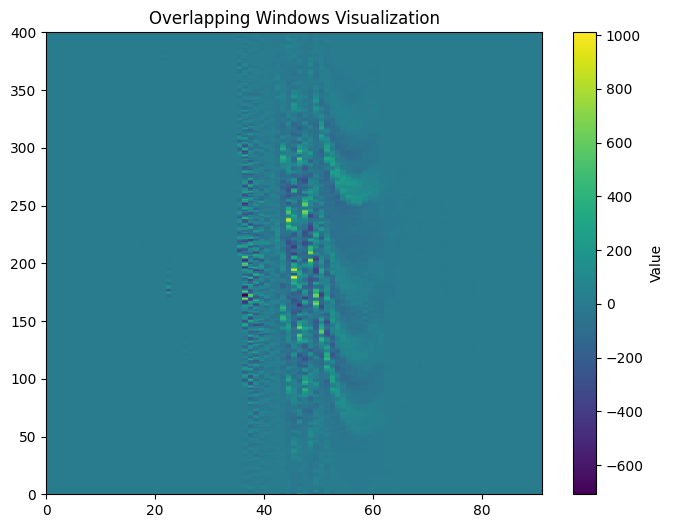

In [15]:
plot(ham.T)

In [16]:
np.allclose(ham,example['windowed'])

True

## FFT

In [17]:
from scipy.fftpack import fft
def powerSpectrum(frames, NFFT=512):
    """
    Computes the power spectrum of each frame in frames, i.e. strength (dB) for each frequency (Hz)

    Args:
        frames: 2D numpy array of windowed frames from the speech signal.
        NFFT: The FFT length.
        
    Returns:
        A 2D numpy array where each row represents the power spectrum of a frame.
    """
    fft_frames = fft(frames, n=NFFT)
    power_spec = np.abs(fft_frames) ** 2
    
    return power_spec

In [18]:
np.allclose(powerSpectrum(ham),example['spec'])

True

The image shows that we are in fact able to break the sound in to a few tones as opposed

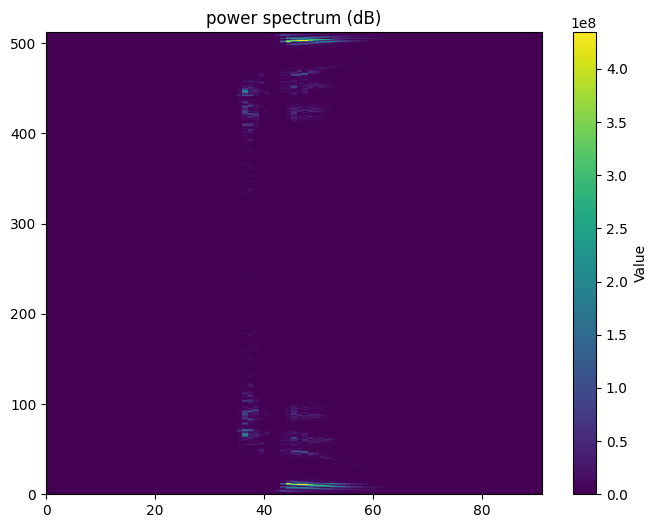

In [63]:
#Symmetric along the middle line of the graph, only light bands in the 50-150 range are interesting.
plot(powerSpectrum(ham).T,title="power spectrum (dB)")

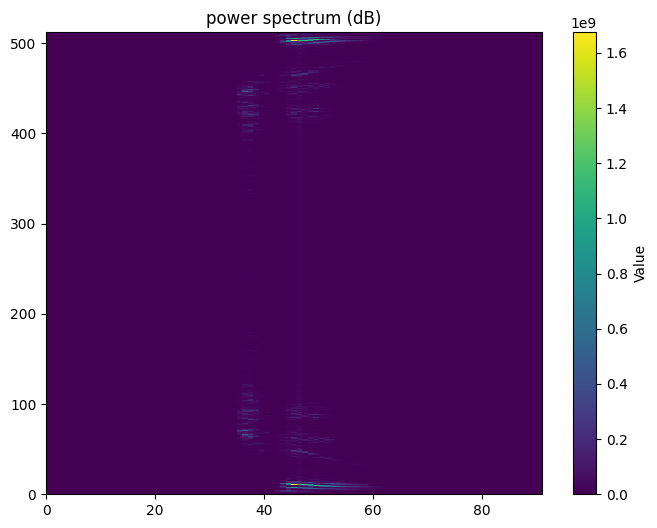

In [64]:
plot(powerSpectrum(preemp(enframe(example["samples"],400,200))).T,title="power spectrum (dB)")

## Mel filterbank log spectrum

In [50]:
from lab1_tools import trfbank,hz2mel
def logMelSpectrum(power_spectrum, sampling_frequency, nfft):
    """
    Applies a mel filterbank to the power spectrum and computes the logarithm of the filterbank energies.
    Intuitively: we view the output of the FFT as a new signal (in the frequency domain) and apply different triangular filters to this signal in order to model
    our human perception of differences in high frequency vs low frequency signals. 

    Args:
        power_spectrum: 2D numpy array of the power spectrum of the speech frames.
        sampling_rate: The sampling rate of the speech signal.
        

    Returns:
        A 2D numpy array where each row represents the log Mel spectrum of a frame.
    """
    # create the triangular filterbank
    fbank = trfbank(sampling_frequency,nfft)
    
    # apply the filters to the power spectrum
    mspec = np.log(np.dot(power_spectrum, fbank.T))
    
    return mspec

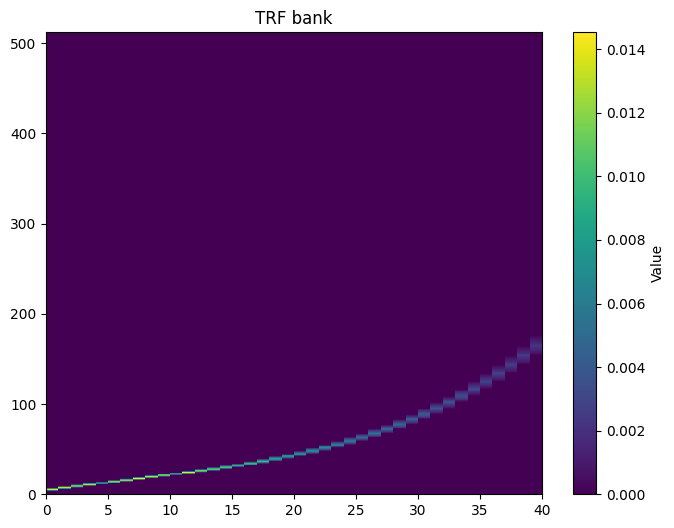

In [75]:
fbank = trfbank(example["samplingrate"],512)
plot(fbank.T,title="TRF bank")

In [67]:
fbank.shape

(40, 512)

In [22]:
logmel = logMelSpectrum(powerSpectrum(ham),example["samplingrate"],512)

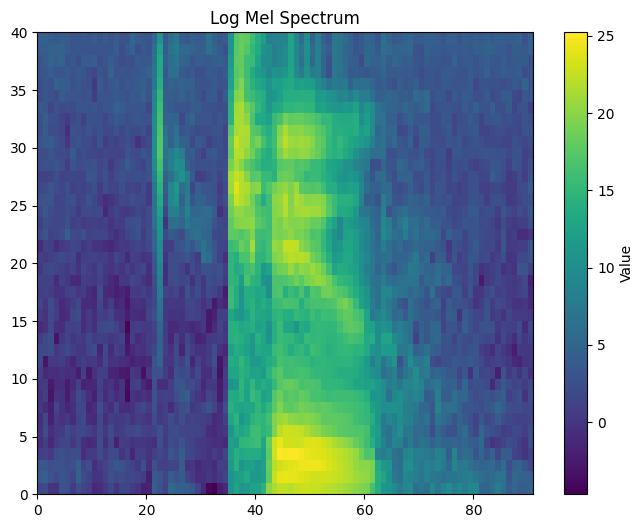

In [73]:
plot(hz2mel(logmel).T,title="Log Mel Spectrum")

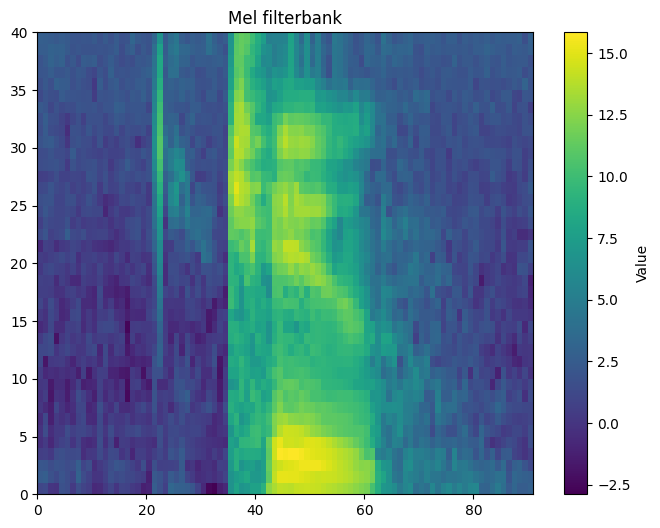

In [72]:
plot(logmel.T,title="Log Mel Spectrum")

In [49]:
np.allclose(logmel,example['mspec'])

True

In [38]:
example['mspec']

array([[ 1.01494729,  2.40587062,  2.12126572, ...,  2.00733073,
         2.58873636,  2.67833857],
       [ 1.27846121,  2.66685394,  2.02279656, ...,  2.3526525 ,
         2.5551395 ,  2.63361125],
       [-0.0065844 ,  1.77541774,  1.45795469, ...,  2.9875043 ,
         2.94912365,  2.48856204],
       ...,
       [ 2.54992124,  3.01080195,  3.00681818, ...,  2.28560639,
         2.43392306,  2.76641543],
       [ 2.58620099,  2.80232025,  1.94883687, ...,  2.26038805,
         2.24652569,  1.62972399],
       [ 2.88678984,  2.61225053,  1.15979777, ...,  1.64698766,
         2.72943372,  2.82326989]])

In [48]:
hz2mel(logmel)

array([[ 1.63289683,  3.86684643,  3.41010521, ...,  3.22720754,
         4.16021639,  4.30393658],
       [ 2.05646433,  4.28551649,  3.25203628, ...,  3.78145469,
         4.10632295,  4.23219712],
       [-0.01060104,  2.85483029,  2.34488777, ...,  4.7996917 ,
         4.73815921,  3.99951703],
       ...,
       [ 4.09795199,  4.83704125,  4.83065477, ...,  3.67386591,
         3.91185567,  4.44519228],
       [ 4.15614943,  4.50277055,  3.13329693, ...,  3.6333954 ,
         3.61114841,  2.62083033],
       [ 4.63821745,  4.19793443,  1.86574656, ...,  2.64856019,
         4.385884  ,  4.53636479]])

## Cosine Transofrm and Liftering

In [51]:
from scipy.fftpack.realtransforms import dct
from lab1_tools import lifter  # Make sure to import the lifter function correctly

def cepstrum(input, nceps):
    """
    Calculates Cepstral coefficients from mel spectrum applying Discrete Cosine Transform (DCT).

    Args:
        input: 2D numpy array of log outputs of Mel scale filterbank [N x nmelfilters], where N is the
               number of frames and nmelfilters the length of the filterbank.
        nceps: Number of output cepstral coefficients.

    Returns:
        2D numpy array of Cepstral coefficients [N x nceps].
    """
    # apply DCT to the mel-spectrum input
    cepstral_coeffs = dct(input)
    
    # select the first 'nceps' coefficients
    cepstral_coeffs = cepstral_coeffs[:, :nceps]
    
    return cepstral_coeffs

C:\Users\axels\AppData\Local\Temp\ipykernel_18748\959208655.py:1: DeprecationWarning: Please import `dct` from the `scipy.fftpack` namespace; the `scipy.fftpack.realtransforms` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.fftpack.realtransforms import dct


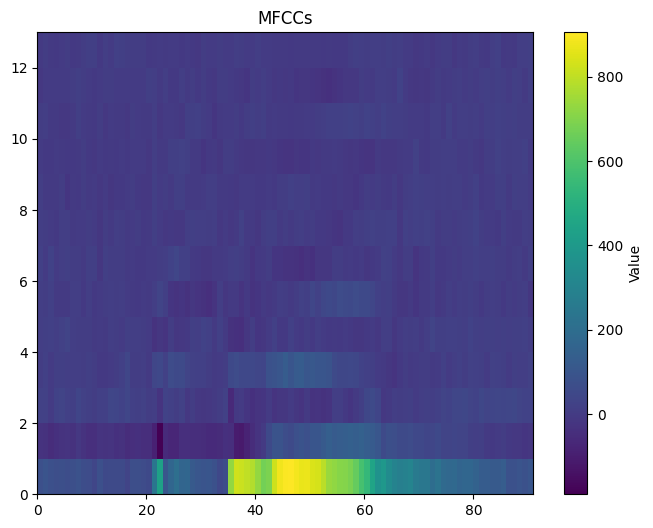

In [71]:
plot(cepstrum(logmel, nceps).T,title="MFCCs")

In [52]:
nceps = 13
np.allclose(cepstrum(logmel, nceps),example['mfcc'])

True

In [53]:
# apply liftering
lft = lifter(cepstrum(logmel, nceps), 22) 
np.allclose(lft,example["lmfcc"])

True

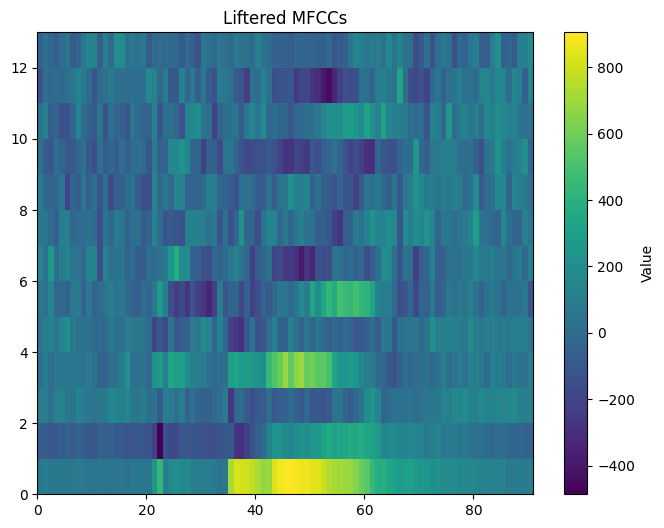

In [77]:
plot(lft.T,title="Liftered MFCCs")

## test mfcc function and mspec function

In [54]:
from lab1_proto import mspec,mfcc
m=mspec(example["samples"])
np.allclose(cepstrum(m,13),example["mfcc"])

True

In [55]:
np.allclose(mfcc(example["samples"]),example["lmfcc"])

True

## 5

In [94]:
mfcc(data[22]["samples"]).shape

(71, 13)

In [56]:
# calculate total number of frames in dataset
mfcc_list = []
M = 13
for datapoint in data:
    mfcc_list.append(mfcc(datapoint["samples"],nceps=M))

In [57]:
# calculate N
N = 0
for i in mfcc_list:
    N+=i.shape[0]
N

3885

In [58]:
X = np.concatenate(mfcc_list, axis=0) # N x M i.e. N frames of M features each
X.shape

(3885, 13)

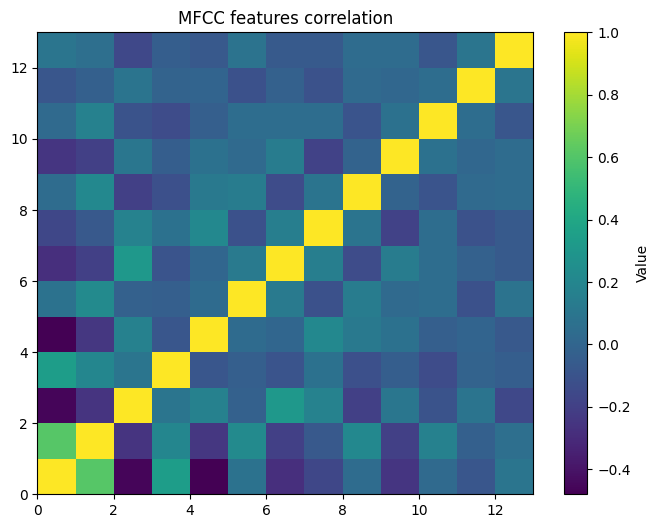

In [78]:
#calculate correlational coefficient
C = np.corrcoef(X.T)
plot(C,title="MFCC features correlation")

In [60]:
#compare with Mel filterbank features
mspec_list = []
M_mel = 13
for datapoint in data:
    mspec_list.append(mspec(datapoint["samples"]))
# calculate N
N_mel = 0
for i in mspec_list:
    N_mel+=i.shape[0]
X_mel = np.concatenate(mspec_list, axis=0) # N x M
X_mel.shape

(3885, 40)

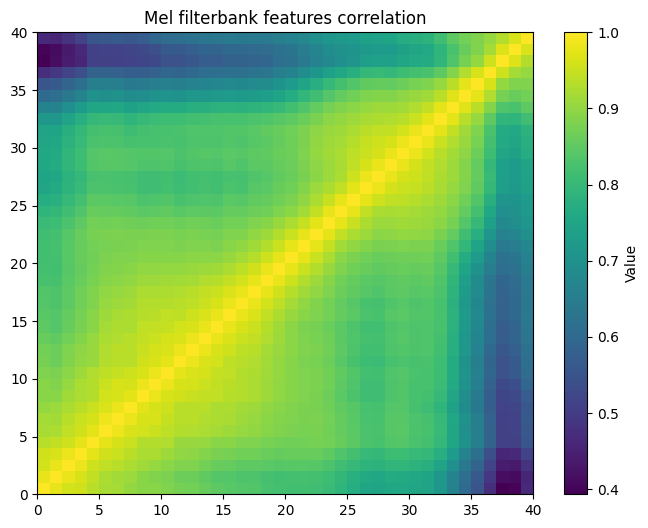

In [79]:
C_mel = np.corrcoef(X_mel.T)
plot(C_mel,title="Mel filterbank features correlation")

## 6

In [83]:
from sklearn.mixture import GaussianMixture


components = [4, 8, 16, 32]

# train GMMs
gmms = [GaussianMixture(n_components=n, covariance_type='diag').fit(X) for n in components]


In [84]:
data[0]

{'filename': '/home/giampi/corpora/tidigits/disc_4.2.1/tidigits/test/man/bm/oa.wav',
 'samplingrate': 20000,
 'gender': 'man',
 'speaker': 'bm',
 'digit': 'o',
 'repetition': 'a',
 'samples': array([-2, -1, -3, ..., 10,  8,  5], dtype=int16)}

In [85]:
#create a list of utterances
from collections import defaultdict

#initialize a dictionary to hold the lists of indices for each digit (class)
class_indices = defaultdict(list)

#iterate through the dataset and populate the dictionary
for index, item in enumerate(data):
    digit_class = item['digit']
    class_indices[digit_class].append(index)

#convert defaultdict to a regular dict for display purposes
class_indices = dict(class_indices)


for digit, indices in class_indices.items():
    print(f"Class '{digit}': {indices}")


Class 'o': [0, 1, 22, 23]
Class 'z': [2, 3, 24, 25]
Class '1': [4, 5, 26, 27]
Class '2': [6, 7, 28, 29]
Class '3': [8, 9, 30, 31]
Class '4': [10, 11, 32, 33]
Class '5': [12, 13, 34, 35]
Class '6': [14, 15, 36, 37]
Class '7': [16, 17, 38, 39]
Class '8': [18, 19, 40, 41]
Class '9': [20, 21, 42, 43]


In [86]:
len(mfcc_list)

44

In [152]:
#assuming 'utterance_features' is a list of arrays, each containing features for a specific utterance
utterance_ids = class_indices["2"]
utterance_features = [mfcc_list[i] for i in utterance_ids]  # Replace mfcc_features with your data structure

#compute GMM posteriors for the chosen utterance using the model with 32 components
model_32 = gmms[1]  # Assuming the last model is the one with 32 components
posteriors = [model_32.predict_proba(features) for features in utterance_features]


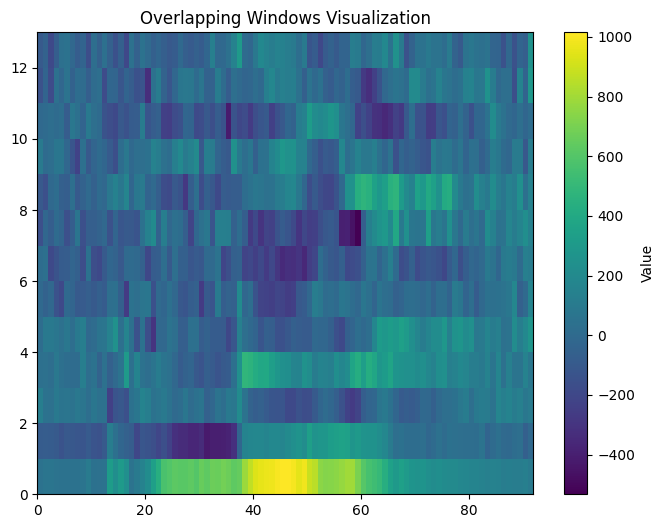

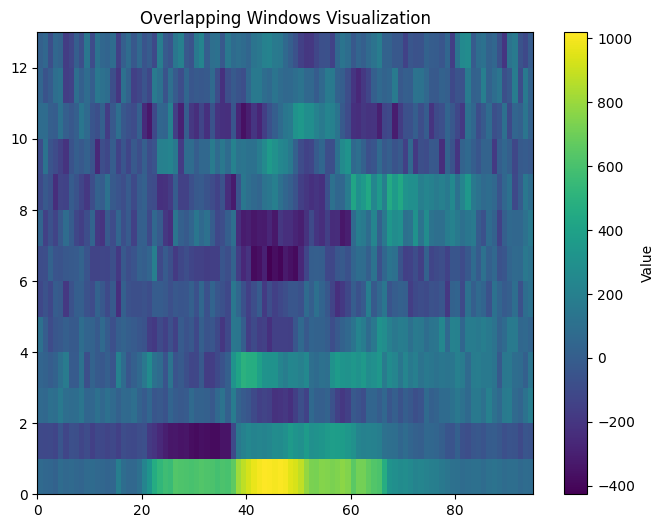

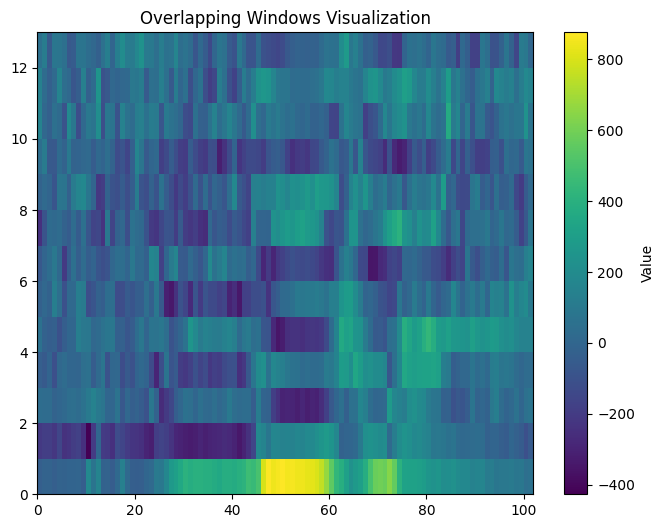

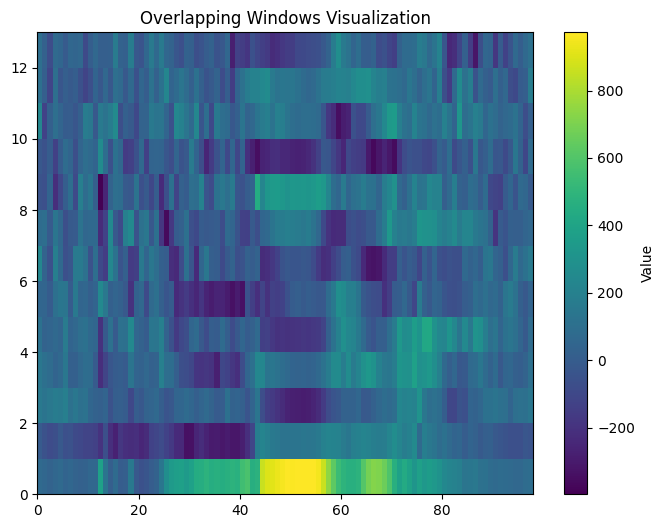

In [90]:
#input data
for feature in utterance_features:
    plot(feature.T)

In [95]:
# ground truth label
for feature in utterance_features:
    plot(mfcc(feature).T)

ValueError: could not broadcast input array from shape (92,13) into shape (400,)

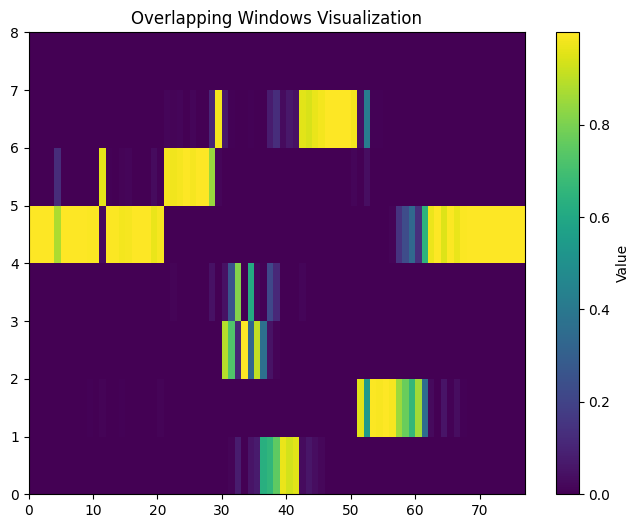

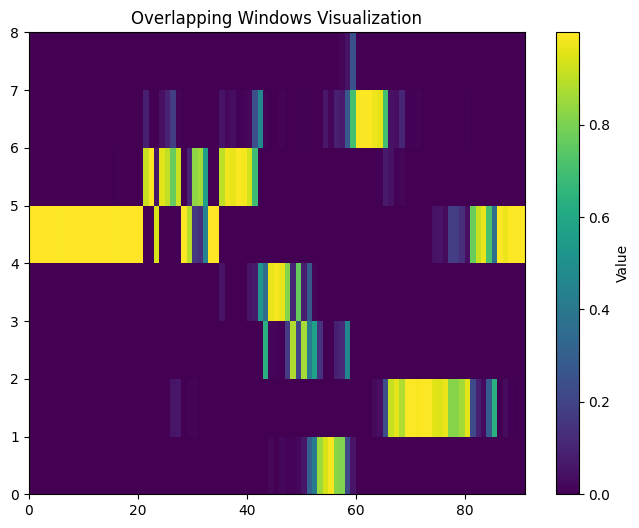

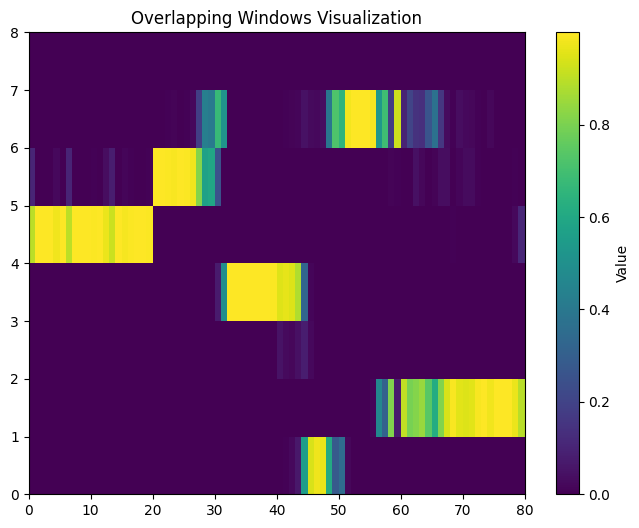

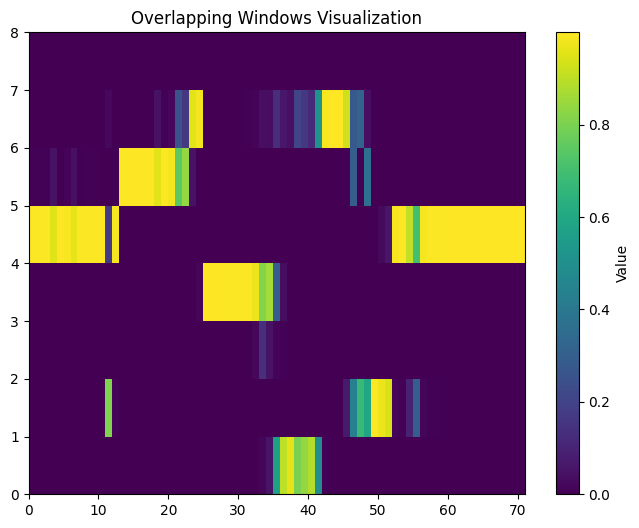

In [153]:
for posterior in posteriors:
    plot(posterior.T)

## 7

In [155]:
# compute euclidean distance
def pairwise_euclidean_distance(mfcc_mat_1,mfcc_mat_2):
    """
    Computes an N x M matrix of euclidean distances between each MFCC vectors

    Args:
        mfcc_mat_1: N x d i.e. N windows
        mfcc_mat_2: M x d i.e. M windows
    """
    N = mfcc_mat_1.shape[0]
    M = mfcc_mat_2.shape[0]
    output = np.zeros((N,M))
    for n in range(N):
        for m in range(M):
            output[n,m] = np.linalg.norm(mfcc_mat_1[n]-mfcc_mat_2[m])
    return output


In [156]:
pairwise_euclidean_distance(mfcc_list[0],mfcc_list[1]).shape

(82, 74)

In [176]:
def dtw_distance(matrix):
    N, M = matrix.shape
    dtw_matrix = np.full((N+1, M+1), np.inf)
    dtw_matrix[0, 0] = 0

    for i in range(1, N+1):
        for j in range(1, M+1):
            cost = matrix[i-1, j-1]
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j],    # insertion
                                          dtw_matrix[i, j-1],    # deletion
                                          dtw_matrix[i-1, j-1])  # match
    #global distance between the two sequences
    #i.e minimum cumulative distance required to align the two sequences. 
    return dtw_matrix[N, M]

def dtw_distance_M(matrix):
    N, M = matrix.shape
    dtw_matrix = np.full((N+1, M+1), np.inf)
    dtw_matrix[0, 0] = 0

    for i in range(1, N+1):
        for j in range(1, M+1):
            cost = matrix[i-1, j-1]
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j],    # insertion
                                          dtw_matrix[i, j-1],    # deletion
                                          dtw_matrix[i-1, j-1])  # match
    #global distance between the two sequences
    #i.e minimum cumulative distance required to align the two sequences. 
    return dtw_matrix

For each pair of utterances in the data array:

In [158]:
len(mfcc_list)

44

In [174]:
data[16]

{'filename': '/home/giampi/corpora/tidigits/disc_4.2.1/tidigits/test/man/bm/7a.wav',
 'samplingrate': 20000,
 'gender': 'man',
 'speaker': 'bm',
 'digit': '7',
 'repetition': 'a',
 'samples': array([-1, -1, -3, ..., 13, 13, 15], dtype=int16)}

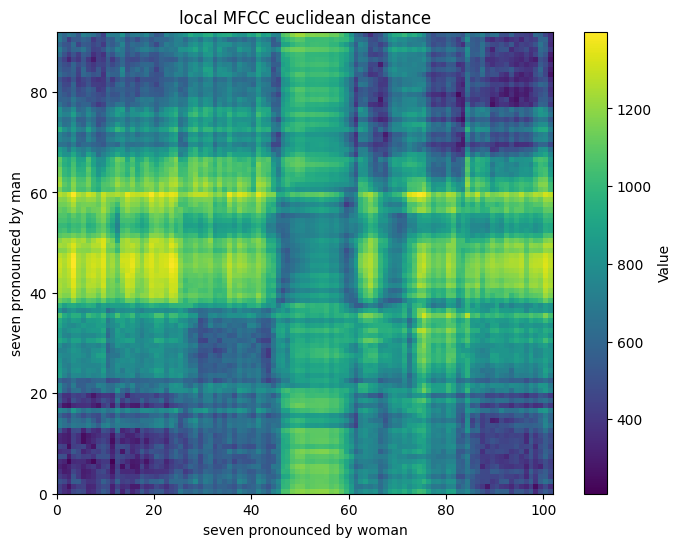

In [182]:
plot(pairwise_euclidean_distance(mfcc_list[16],mfcc_list[38]),title="local MFCC euclidean distance",ylabel="seven pronounced by man",xlabel="seven pronounced by woman")


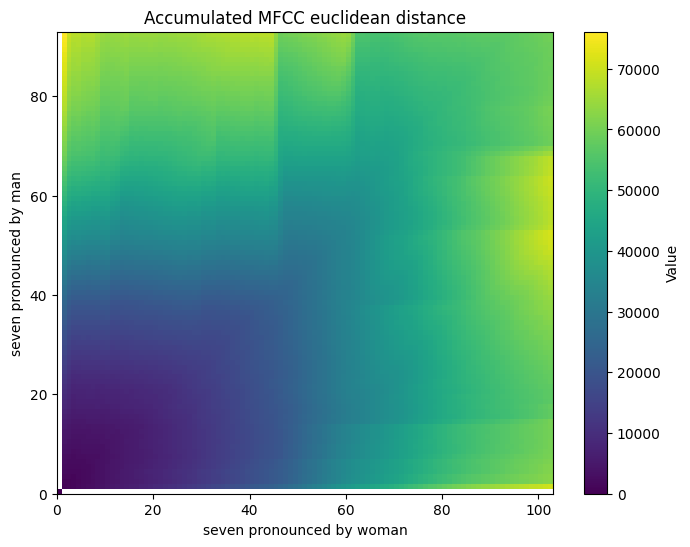

In [180]:
plot(dtw_distance_M(pairwise_euclidean_distance(mfcc_list[16],mfcc_list[38])),title="Accumulated MFCC euclidean distance",ylabel="seven pronounced by man",xlabel="seven pronounced by woman")


In [186]:
D = np.zeros((len(mfcc_list),len(mfcc_list)))
for i in range(len(mfcc_list)):
    for j in range(len(mfcc_list)):
        local_dist_matrix = pairwise_euclidean_distance(mfcc_list[i],mfcc_list[j])
        D[i,j] = dtw_distance(local_dist_matrix)


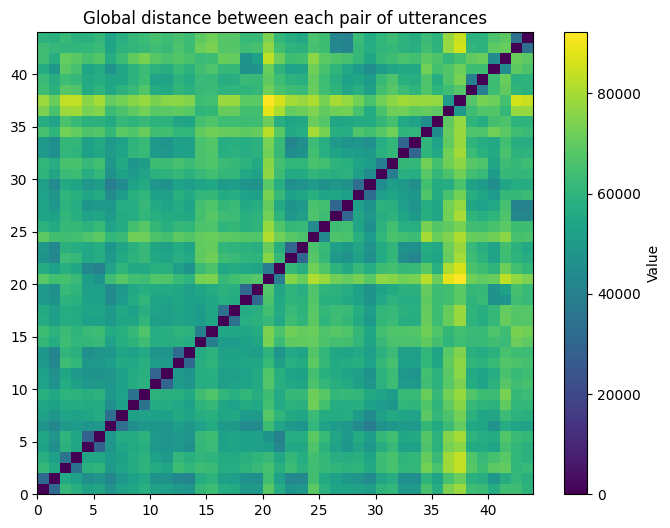

In [187]:
plot(D,title="Global distance between each pair of utterances")

In [161]:
D = np.zeros((len(mfcc_list),len(mfcc_list)))
for i in range(len(mfcc_list)):
    for j in range(len(mfcc_list)):
        local_dist_matrix = pairwise_euclidean_distance(mfcc_list[i],mfcc_list[j])
        D = dtw_distance(local_dist_matrix)

In [191]:
data[1]

{'filename': '/home/giampi/corpora/tidigits/disc_4.2.1/tidigits/test/man/bm/ob.wav',
 'samplingrate': 20000,
 'gender': 'man',
 'speaker': 'bm',
 'digit': 'o',
 'repetition': 'b',
 'samples': array([  0,   0,   4, ..., -14, -12, -11], dtype=int16)}

In [197]:
def tidigit2labels(tidigitsarray):
    """
    Return a list of labels including gender, speaker, digit and repetition information for each
    utterance in tidigitsarray. Useful for plots.
    """
    labels = []
    nex = len(tidigitsarray)
    for ex in range(nex):
        labels.append(tidigitsarray[ex]['gender'] + '_' + 
                      #tidigitsarray[ex]['speaker'] + '_' + 
                      tidigitsarray[ex]['digit']) 
                      #tidigitsarray[ex]['repetition'])
    return labels


hierarchical clustering

C:\Users\axels\AppData\Local\Temp\ipykernel_18748\2286296145.py:4: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(D, method='complete')


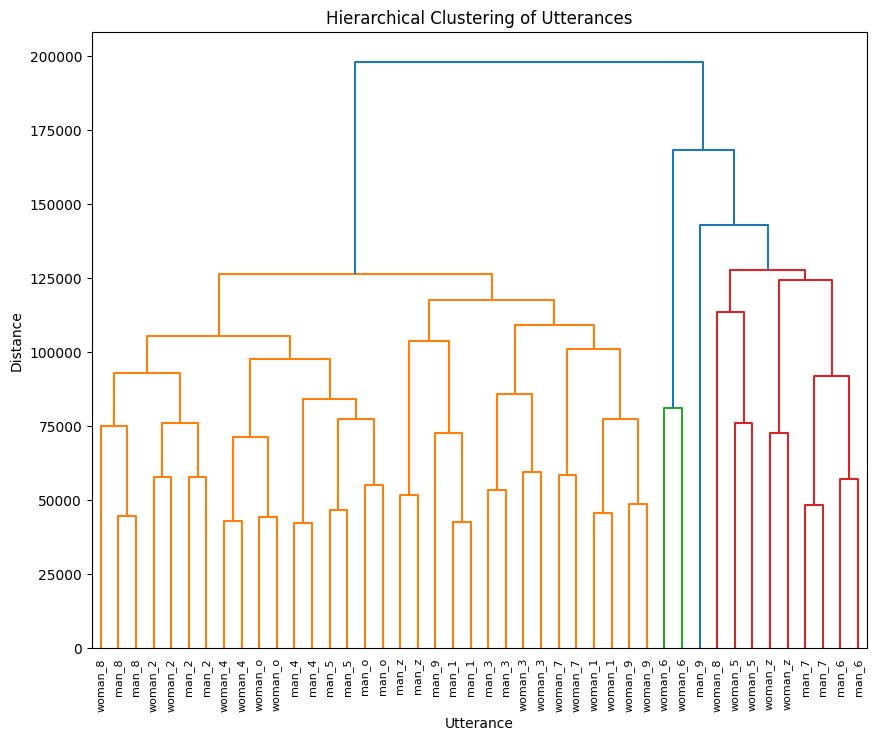

In [198]:
from scipy.cluster.hierarchy import dendrogram, linkage
#from lab1_tools import tidigit2labels
#run hierarchical clustering
Z = linkage(D, method='complete')

#plot dendrogram
plt.figure(figsize=(10, 8))
dendrogram(Z, labels=tidigit2labels(data), leaf_rotation=90)
plt.title('Hierarchical Clustering of Utterances')
plt.xlabel('Utterance')
plt.ylabel('Distance')
plt.show()